In [602]:
import numpy as np
import matplotlib.pyplot as plt

In [603]:
from loaders import clean_text_for_pattern_letter
from temp_text import template_str
input_str = clean_text_for_pattern_letter(template_str, out_len=500)
print(len(input_str))
letters = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u',
               'v', 'w', 'x', 'y', 'z', ' ', '.', ',', '"', '\'', '1']
print(f'{letters=}')

len(letters)=32
500
letters=['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', ' ', '.', ',', '"', "'", '1']


In [604]:
def predict_train(input_str, letters, max_index: int = 4,):
    index_winner: dict[str, list] = {}
    index_by_prev: dict[str, dict] = {}

    StatsDict: dict[str, dict] = {}

    for letter in letters:
        index_winner[letter] = [0 for x in range(max_index)]
    # print(f'{index_winner=}')

    prev_index = 1

    for inp_idx, inp in enumerate(input_str):
        if inp_idx <= 0:
            continue

        prev_idx = inp_idx - 1
        prev_inp = input_str[prev_idx]

        by_prev_key = prev_inp + str(prev_index) + ':' + inp

        has_prev = index_by_prev.get(by_prev_key, -1)
        if has_prev != -1:
            inp_index = list(index_by_prev[by_prev_key].keys())[0]
        else:
            index_key = index_winner[inp].index(min(index_winner[inp]))
            inp_index = index_key + 1
            index_winner[inp][index_key] += 1
        # print(f'{inp_index=}')
        stats_key = prev_inp + str(prev_index)
        StatsDict.setdefault(stats_key, {})

        StatsDict[stats_key].setdefault(inp, 0)

        StatsDict[stats_key][inp] += 1

        index_by_prev.setdefault(by_prev_key, {})
        index_by_prev[by_prev_key].setdefault(inp_index, 0)
        index_by_prev[by_prev_key][inp_index] += 1

        # recursion
        prev_index = inp_index
    
    print(f'{index_winner=}')
    for key, ibp in index_by_prev.items():
        print(f'{key} {ibp}')
    
    print(f'{index_winner=}')
    for key, ibp in StatsDict.items():
        print(f'{key} {ibp}')

    return StatsDict, index_by_prev


In [605]:
# predict_train(letters=letters, input_str=input_str, max_index=4)

In [606]:
def predict_old(input_str, TF:list, StatsDict:dict, index_by_prev:dict, max_index, err = 0,):
    prev_index_l = [x for x in range(1, max_index+1)]

    output = []

    for inp_idx, inp in enumerate(input_str):
        if inp_idx == len(input_str) - 1:
            continue

        prev_inp = input_str[inp_idx - 1]
        
        index_l = []
        stats_d = {}
        index_d = {}
        for prev_index in prev_index_l:
            by_prev_key = prev_inp + str(prev_index) + ':' + inp
            print(f'{by_prev_key=}')
            inp_index_arr = index_by_prev.get(by_prev_key, {-1: -1})
            print(f'{inp_index_arr=}')

            for inp_index, val in inp_index_arr.items():
                if inp_index != -1:
                    index_d.setdefault(inp_index, 0)
                    index_d[inp_index] += val

                if inp_index != -1 and index_l.__contains__(inp_index) == False:
                    index_l.append(inp_index)

                    stats_key = prev_inp + str(prev_index)
                    stats = StatsDict.get(stats_key, {})

                    next_inp = input_str[inp_idx + 1]
                    # print(next_inp, stats_key, stats)
                    for st_key, st in stats.items():
                        stats_d.setdefault(st_key, 0)
                        stats_d[st_key] += 1
        print(f'{index_d=}')
        # max_key_d = max(index_d, key=index_d.get)
        # if inp == prev_inp:
        #     pred_max_key = max_key_d
        #     max_key_d += 1
        #     if max_key_d > max_index:
        #         max_key_d = 1
            
        #     index_d[max_key_d] = index_d[pred_max_key]
        #     index_d.pop(pred_max_key)

        if len(stats_d) > 0:
            max_key = max(stats_d, key=stats_d.get)
            print(max_key, next_inp, stats_d, index_l, index_d, prev_index_l, inp == prev_inp)
            # B B {'B': 1} [3] {3: 1} [3] False
            output.append(max_key)

        prev_index_l = list(index_d.keys())
        
        if max_key != next_inp:
            err += 1

        stats_arr = np.array(list(stats_d.values()))
        predictability = np.sum(np.abs(stats_arr - stats_arr[np.newaxis].T))
        tf = predictability
        TF.append(tf)
    
    output.insert(0, input_str[1])
    
    return TF, err, output

In [607]:
# train
max_index_L1 = 32

index_by_prev_L1: dict[str, dict] = {}
StatsDict_L1: dict[str, dict] = {}

StatsDict, index_by_prev_L1 = predict_train(letters=letters, input_str=input_str, max_index=max_index_L1)

index_winner={'a': [2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'b': [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'c': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'd': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'e': [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'f': [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'g': [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'h': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'i': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0], 'j': [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [608]:
for sdk, sdv in index_by_prev_L1.items():
    print(sdk, sdv)
    print('')

t1:h {1: 3}

h1:e {1: 3}

e1:  {1: 3}

 1:s {1: 1}

s1:k {1: 1}

k1:y {1: 1}

y1:  {2: 1}

 2:a {1: 1}

a1:b {1: 1}

b1:o {1: 1}

o1:v {1: 1}

v1:e {2: 1}

e2:  {3: 1}

 3:t {1: 2}

 1:p {1: 1}

p1:o {2: 1}

o2:r {1: 1}

r1:t {2: 1}

t2:  {4: 1}

 4:w {1: 2}

w1:a {2: 1}

a2:s {2: 1}

s2:  {5: 1}

 5:t {3: 1}

t3:h {2: 1}

h2:e {3: 1}

e3:  {6: 1}

 6:c {1: 1}

c1:o {3: 1}

o3:l {1: 1}

l1:o {4: 1}

o4:r {2: 1}

r2:  {7: 1}

 7:o {5: 1}

o5:f {1: 1}

f1:  {8: 1}

 8:t {4: 2}

t4:e {4: 1}

e4:l {2: 1}

l2:e {5: 1}

e5:v {2: 1}

v2:i {1: 1}

i1:s {3: 1}

s3:i {2: 1}

i2:o {6: 1}

o6:n {1: 1}

n1:, {1: 1}

,1:  {9: 1}

 9:t {5: 2}

t5:u {1: 1}

u1:n {2: 1}

n2:e {6: 1}

e6:d {1: 1}

d1:  {10: 1}

 10:t {6: 1}

t6:o {7: 1}

o7:  {11: 1}

 11:a {3: 1}

a3:  {12: 1}

 12:d {2: 2}

d2:e {7: 2}

e7:a {4: 1}

a4:d {3: 1}

d3:  {13: 1}

 13:c {2: 1}

c2:h {3: 1}

h3:a {5: 1}

a5:n {3: 1}

n3:n {4: 1}

n4:e {8: 1}

e8:l {3: 1}

l3:. {1: 1}

.1:  {14: 1}

 14:" {1: 1}

"1:i {3: 1}

i3:t {7: 1}

t7

In [609]:
for sdk, sdv in StatsDict.items():
    print(sdk, sdv)
    print('')

t1 {'h': 3}

h1 {'e': 3}

e1 {' ': 3, 'e': 1}

 1 {'s': 1, 'p': 1, 'd': 1, 'c': 1, 't': 1}

s1 {'k': 1}

k1 {'y': 1}

y1 {' ': 1}

 2 {'a': 1, 'o': 1, 'f': 1}

a1 {'b': 1, 's': 1}

b1 {'o': 1}

o1 {'v': 1, 't': 1}

v1 {'e': 1}

e2 {' ': 1, 'k': 1}

 3 {'t': 2, 'a': 1}

p1 {'o': 1}

o2 {'r': 1, 'n': 1}

r1 {'t': 1}

t2 {' ': 1}

 4 {'w': 2, '"': 1}

w1 {'a': 1, 'e': 1}

a2 {'s': 1, 'r': 1}

s2 {' ': 1}

 5 {'t': 1, 'l': 1, 'a': 1}

t3 {'h': 1}

h2 {'e': 1}

e3 {' ': 1, 'v': 1}

 6 {'c': 1, 'm': 1, 'n': 1}

c1 {'o': 1}

o3 {'l': 1, 'u': 1}

l1 {'o': 1}

o4 {'r': 1}

r2 {' ': 1}

 7 {'o': 1, 'b': 1, 'h': 1}

o5 {'f': 1}

f1 {' ': 1}

 8 {'t': 2, 'd': 1}

t4 {'e': 1, 'w': 1}

e4 {'l': 1, 'r': 1}

l2 {'e': 1}

e5 {'v': 1, 'a': 1}

v2 {'i': 1}

i1 {'s': 1}

s3 {'i': 1}

i2 {'o': 1}

o6 {'n': 1}

n1 {',': 1}

,1 {' ': 1}

 9 {'t': 2, 'w': 1}

t5 {'u': 1, 'h': 1}

u1 {'n': 1}

n2 {'e': 1}

e6 {'d': 1, 's': 1}

d1 {' ': 1}

 10 {'t': 1, 'm': 1, 'i': 1}

t6 {'o': 1}

o7 {' ': 1}

 11 {'a': 1, 'd

In [610]:
from collections import Counter


def predict(input_str, TF: list, StatsDict: dict, index_by_prev: dict, max_index, err=0,):
    indexes = [x for x in range(1, max_index+1)]

    output = []

    for inp_idx, inp in enumerate(input_str):
        if inp_idx == len(input_str) - 1:
            continue

        all_indexes_prd_symbols = Counter({})
        prd_symbols_per_index = []

        for index in indexes:
            stats_key = inp + str(index)
            prd_symbols = StatsDict.get(stats_key)

            if not prd_symbols:
                print(f'not prd_symbol: {inp=} {index=} {prd_symbols=}')
                continue

            print(f'{inp=} {index=} {prd_symbols=}')
            all_indexes_prd_symbols += Counter(prd_symbols)
            prd_symbols_per_index.append(prd_symbols)

        print(f'{all_indexes_prd_symbols=}')
        tf = len(list(all_indexes_prd_symbols.keys()))
        TF.append(tf)

        prd_symbol = max(all_indexes_prd_symbols, key=all_indexes_prd_symbols.get)
        prd_symbol_stats = all_indexes_prd_symbols[prd_symbol]

        next_inp = input_str[inp_idx + 1]
        print(f'{inp_idx=} {inp=} | {prd_symbol=} {next_inp=} {prd_symbol_stats=}')

        if prd_symbol != next_inp:
            err += 1

        output.append(prd_symbol)

        prev_indexes = []
        for idx, prd_symbols in enumerate(prd_symbols_per_index):
            if prd_symbols.__contains__(next_inp):
                prev_indexes.append(idx + 1)

        print(f'{prev_indexes=}')
        if len(prev_indexes) <= 0:
            prev_indexes = [x for x in range(1, max_index+1)]

        prd_indexes = Counter({})
        
        for prev_index in prev_indexes:
            by_prev_key = inp + str(prev_index) + ':' + next_inp
            next_index_stats = index_by_prev.get(by_prev_key)

            if not next_index_stats:
                continue
            
            prd_indexes += Counter(next_index_stats)
            print(f'{next_index_stats}')
        
        print(f'{prd_indexes=}')
        if len(prd_indexes) == 0:
            prd_indexes += {1:1}
            
        max_index_key = max(prd_indexes, key=prd_indexes.get)
        
        print(f'{max_index_key=}')

        indexes = [max_index_key]
        print('next indexes', indexes)
        
        if len(indexes) <= 0:
            indexes = [x for x in range(1, max_index+1)]

        print(f'{err=}')
        print()
        
    output.insert(0, input_str[0])

    return TF, err, output


In [611]:
# predict
TF = []

TF, err, out_L1 = predict(input_str=input_str, TF=TF, StatsDict=StatsDict, index_by_prev=index_by_prev_L1, max_index=max_index_L1)

print(err, err / (len(input_str) / 100) )

inp='t' index=1 prd_symbols={'h': 3}
inp='t' index=2 prd_symbols={' ': 1}
inp='t' index=3 prd_symbols={'h': 1}
inp='t' index=4 prd_symbols={'e': 1, 'w': 1}
inp='t' index=5 prd_symbols={'u': 1, 'h': 1}
inp='t' index=6 prd_symbols={'o': 1}
inp='t' index=7 prd_symbols={"'": 1}
inp='t' index=8 prd_symbols={' ': 1}
inp='t' index=9 prd_symbols={'h': 1}
inp='t' index=10 prd_symbols={'h': 1}
inp='t' index=11 prd_symbols={'h': 1}
inp='t' index=12 prd_symbols={'.': 1}
inp='t' index=13 prd_symbols={"'": 1}
inp='t' index=14 prd_symbols={' ': 1}
inp='t' index=15 prd_symbols={'h': 1}
inp='t' index=16 prd_symbols={'s': 1}
inp='t' index=17 prd_symbols={'r': 1}
inp='t' index=18 prd_symbols={'e': 1}
inp='t' index=19 prd_symbols={'h': 1}
inp='t' index=20 prd_symbols={'z': 1}
inp='t' index=21 prd_symbols={'e': 1}
inp='t' index=22 prd_symbols={'h': 1}
inp='t' index=23 prd_symbols={'i': 1}
inp='t' index=24 prd_symbols={'o': 1}
not prd_symbol: inp='t' index=25 prd_symbols=None
not prd_symbol: inp='t' index=2

In [612]:
# def transition_freedom(input_str: str):
#     transition_freedom: dict[str, dict] = {}

#     for inp_idx, inp in enumerate(input_str):
#         if inp_idx <= 0:
#             continue

#         prev_idx = inp_idx - 1
#         prev_inp = input_str[prev_idx]

#         transition_freedom.setdefault(prev_inp, {})
#         transition_freedom[prev_inp].setdefault(inp, 0)

#     # print(transition_freedom)

#     for tf_key, tf in transition_freedom.items():
#         transition_freedom[tf_key] = len(tf)
    
#     # print(transition_freedom)

#     return transition_freedom
        
# TF_per_symbol = transition_freedom(input_str)
# TF = []
# for inp in input_str:
#     TF.append(TF_per_symbol[inp])
# print(len(TF), TF)

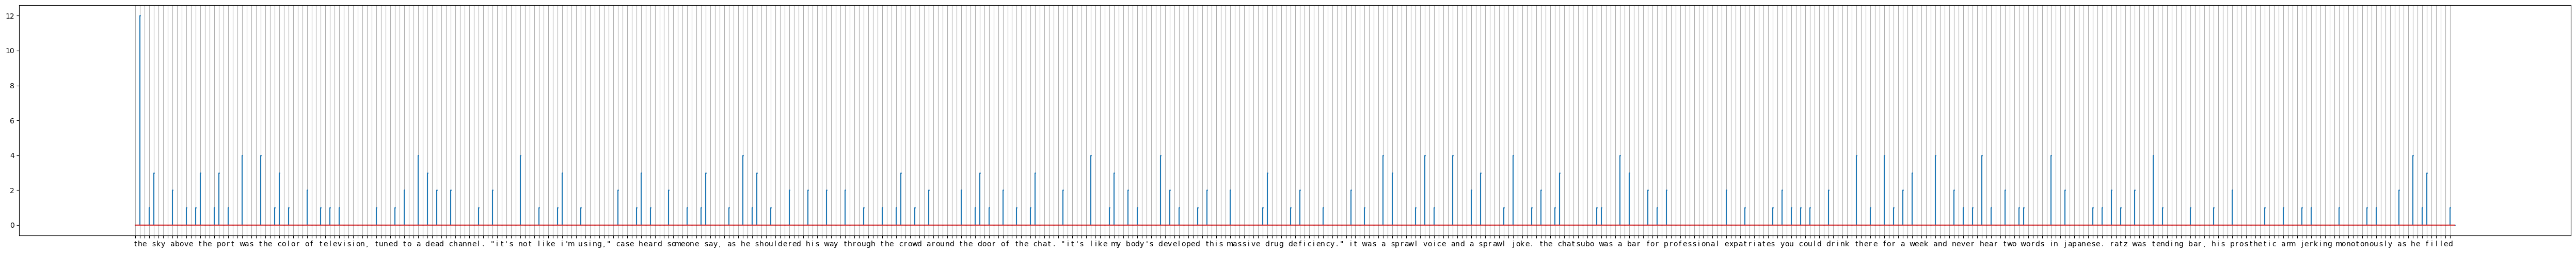

In [613]:
TF = np.array(TF, dtype=float)
# print(TF)
TF = np.pad(TF, (1, 1), constant_values=[0,0])
# # print(TF)
# TF = np.pad(TF, (1, 0))[:-1] - TF
# TF = TF - np.pad(TF, (1, 0))[:-1] 
# # TF = np.pad(TF, (1, 0))[:-1] - TF
# # TF = TF - np.pad(TF, (0, 1))[-1:]
# # print(TF)
# TF[np.where(TF < 0)] = 0

for idx in range(1):
    TF = TF - np.pad(TF, (1, 0))[:-1]
    TF[np.where(TF < 0)] = 0
    # TF[np.where(TF <= np.mean(TF[np.where(TF > 0)]))] = 0
# # TF = np.abs(TF)
# TF[np.where(TF <= np.mean(TF[np.where(TF > 0)]))] = 0
# # TF[np.where(TF <= 0.5)] = 0
# print(TF.size, TF.max(), TF.min())
# TF[np.where(TF <= np.mean(TF))] = 0

fig, axs = plt.subplots(1, 1, figsize=(50, 5), tight_layout=True)
# axs.plot(np.arange(TF.size), TF)
markerline, stemline, baseline, = axs.stem(np.arange(TF.size), TF)
plt.setp(markerline, markersize = 1)
axs.xaxis.set_ticks(np.arange(len(input_str)) ,input_str)
axs.xaxis.grid(True)

plt.show()

In [614]:
upstream_inp: dict[int, list] = {}

temp_seq = []

for inp_idx, inp in enumerate(input_str):
    tf = TF[inp_idx]
    
    if tf > 0:
        upstream_inp.setdefault(inp_idx, temp_seq.copy())
        temp_seq.clear()

    temp_seq.append(inp)

for item, val in upstream_inp.items():
    print(item, val)
    
print(len(upstream_inp))

1 ['t']
3 ['h', 'e']
4 [' ']
8 ['s', 'k', 'y', ' ']
11 ['a', 'b', 'o']
13 ['v', 'e']
14 [' ']
17 ['t', 'h', 'e']
18 [' ']
20 ['p', 'o']
23 ['r', 't', ' ']
27 ['w', 'a', 's', ' ']
30 ['t', 'h', 'e']
31 [' ']
33 ['c', 'o']
37 ['l', 'o', 'r', ' ']
40 ['o', 'f', ' ']
42 ['t', 'e']
44 ['l', 'e']
52 ['v', 'i', 's', 'i', 'o', 'n', ',', ' ']
56 ['t', 'u', 'n', 'e']
58 ['d', ' ']
61 ['t', 'o', ' ']
63 ['a', ' ']
65 ['d', 'e']
68 ['a', 'd', ' ']
74 ['c', 'h', 'a', 'n', 'n', 'e']
77 ['l', '.', ' ']
83 ['"', 'i', 't', "'", 's', ' ']
87 ['n', 'o', 't', ' ']
91 ['l', 'i', 'k', 'e']
92 [' ']
96 ['i', "'", 'm', ' ']
104 ['u', 's', 'i', 'n', 'g', ',', '"', ' ']
108 ['c', 'a', 's', 'e']
109 [' ']
111 ['h', 'e']
115 ['a', 'r', 'd', ' ']
119 ['s', 'o', 'm', 'e']
122 ['o', 'n', 'e']
123 [' ']
128 ['s', 'a', 'y', ',', ' ']
131 ['a', 's', ' ']
133 ['h', 'e']
134 [' ']
137 ['s', 'h', 'o']
141 ['u', 'l', 'd', 'e']
145 ['r', 'e', 'd', ' ']
149 ['h', 'i', 's', ' ']
153 ['w', 'a', 'y', ' ']
157 ['t', 'h', 'r', 'o

In [615]:
letters_dict: dict[str, int] = {}
for let_idx, letter in enumerate(letters):
    letters_dict.setdefault(letter, let_idx)

upstream_patterns = []

for upstream_letters in upstream_inp.values():
    upstream_pattern = np.zeros(len(letters))

    for letter in upstream_letters:
        pattern_idx = letters_dict.get(letter, 0)

        upstream_pattern[pattern_idx] = 1
    
    upstream_patterns.append(upstream_pattern)

upstream_patterns = np.array(upstream_patterns)

for up_ptr in upstream_patterns:
    print(up_ptr.astype(int).tolist())

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0]
[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [616]:
layer_size = 32

I = np.zeros(upstream_patterns.shape[1])
O = np.zeros(layer_size)
W = np.ones((O.size, I.size))
Trace = np.zeros((O.size, I.size))
print('W', W.shape, W.max(), W.min(), np.median(W))

k = 1
push_delta = 0.4

prec = 1e-30

epoch_cnt = 100
eps0 = 0.02

eps = 0.05
rate_drop = 0.0

AVG_O = np.zeros(O.shape)
AVG_O_CNT = np.zeros(O.shape)

samples_idx = np.arange(upstream_patterns.shape[0])

for epoch_idx in range(epoch_cnt):
    np.random.shuffle(samples_idx)

    for i_idx in samples_idx:
        I = upstream_patterns[i_idx]

        # infer
        O = np.dot(W, I)

        # train
        winner_ids = np.argsort(O)[::-1][:1+k]
        winner = winner_ids[0]
        loosers = winner_ids[1:1+k]

        # update
        W[winner] = (1 - eps) * W[winner] + eps * (I - 0.5) + Trace[winner]*eps
        W[winner] = np.clip(W[winner], -1, 1)

        # W[loosers] = (1 - eps) * W[loosers] + (eps * (I - 0.5) * -push_delta) + Trace[loosers]*eps
        # W[loosers] = np.clip(W[loosers], -1, 1)

        # update Trace
        rate_Trace = np.zeros(I.shape)
        rate_Trace[(I > 0.5)] = 0.3
        rate_Trace[(I < 0.5)] = -0.001

        dTrace = np.zeros(W.shape)
        dTrace[winner] = rate_Trace
        Trace += dTrace
        Trace = np.clip(Trace, 0, 1)

        eps -= eps * rate_drop

print('W', W.shape, W.max(), W.min(), np.median(W))

W (32, 32) 1.0 1.0 1.0
W (32, 32) 1.0 -0.4999999999999995 -0.499999704269273


In [617]:
SL_symbols = [x.capitalize() for x in letters][:layer_size]
print(len(SL_symbols))

SLSymbolDict = {}

SL_symbols_d = {}
for idx, val in enumerate(SL_symbols):
    SL_symbols_d.setdefault(val + ':' + str(idx), 0)

upstream_inp_keys = list(upstream_inp.keys())

upstream_cluster_by_symbol: dict[str, int] = {}
for idx, val in enumerate(SL_symbols):
    upstream_cluster_by_symbol.setdefault(val, idx)

for upstr_idx, up_ptr in enumerate(upstream_patterns):
    O = np.dot(W, up_ptr)

    winner = np.argmax(O)
    symbol = SL_symbols[winner]
    print(SL_symbols[winner])

    # print(W[upstream_cluster_by_symbol[symbol]].tolist())

    sls = SL_symbols[winner]
    sls_key = upstream_inp_keys[upstr_idx]
    SLSymbolDict.setdefault(sls_key, sls)
    
    SL_symbols_d[SL_symbols[winner] + ':' + str(winner)] += 1

print(len(SL_symbols_d))
for key, val in SL_symbols_d.items():
    print(key, val)

print(SLSymbolDict)

32
B
C
B
D
J
I
B
C
B
H
L
Y
C
B
 
L
A
C
R
G
"
X
B
M
N
V
"
P
S
B
O
B
S
G
K
B
C
V
H
F
B
G
Y
C
B
H
R
N
Z
Y
L
.
C
B
L
W
V
C
B
W
L
A
C
B
Z
S
O
B
.
J
S
N
I
H
X
Z
K
B
V
N
K
G
E
Y
M
Y
Q
 
E
X
M
Y
Q
O
P
C
B
Z
B
Y
M
'
A
U
K
T
K
D
,
.
 
Q
X
C
U
A
U
M
W
X
"
I
U
C
'
L
B
W
X
T
K
P
'
B
Y
C
X
'
Z
H
E
'
T
X
B
F
D
Y
C
B
K
32
A:0 4
B:1 22
C:2 14
D:3 3
E:4 3
F:5 2
G:6 4
H:7 5
I:8 3
J:9 2
K:10 7
L:11 6
M:12 5
N:13 4
O:14 3
P:15 3
Q:16 3
R:17 2
S:18 4
T:19 3
U:20 4
V:21 4
W:22 4
X:23 8
Y:24 9
Z:25 5
 :26 3
.:27 3
,:28 1
":29 3
':30 5
1:31 0
{1: 'B', 3: 'C', 4: 'B', 8: 'D', 11: 'J', 13: 'I', 14: 'B', 17: 'C', 18: 'B', 20: 'H', 23: 'L', 27: 'Y', 30: 'C', 31: 'B', 33: ' ', 37: 'L', 40: 'A', 42: 'C', 44: 'R', 52: 'G', 56: '"', 58: 'X', 61: 'B', 63: 'M', 65: 'N', 68: 'V', 74: '"', 77: 'P', 83: 'S', 87: 'B', 91: 'O', 92: 'B', 96: 'S', 104: 'G', 108: 'K', 109: 'B', 111: 'C', 115: 'V', 119: 'H', 122: 'F', 123: 'B', 128: 'G', 131: 'Y', 133: 'C', 134: 'B', 137: 'H', 141: 'R', 145: 'N', 149: 'Z', 153: 'Y', 157: 'L', 16

In [618]:
sl_input = list(SLSymbolDict.values())
print(sl_input)

['B', 'C', 'B', 'D', 'J', 'I', 'B', 'C', 'B', 'H', 'L', 'Y', 'C', 'B', ' ', 'L', 'A', 'C', 'R', 'G', '"', 'X', 'B', 'M', 'N', 'V', '"', 'P', 'S', 'B', 'O', 'B', 'S', 'G', 'K', 'B', 'C', 'V', 'H', 'F', 'B', 'G', 'Y', 'C', 'B', 'H', 'R', 'N', 'Z', 'Y', 'L', '.', 'C', 'B', 'L', 'W', 'V', 'C', 'B', 'W', 'L', 'A', 'C', 'B', 'Z', 'S', 'O', 'B', '.', 'J', 'S', 'N', 'I', 'H', 'X', 'Z', 'K', 'B', 'V', 'N', 'K', 'G', 'E', 'Y', 'M', 'Y', 'Q', ' ', 'E', 'X', 'M', 'Y', 'Q', 'O', 'P', 'C', 'B', 'Z', 'B', 'Y', 'M', "'", 'A', 'U', 'K', 'T', 'K', 'D', ',', '.', ' ', 'Q', 'X', 'C', 'U', 'A', 'U', 'M', 'W', 'X', '"', 'I', 'U', 'C', "'", 'L', 'B', 'W', 'X', 'T', 'K', 'P', "'", 'B', 'Y', 'C', 'X', "'", 'Z', 'H', 'E', "'", 'T', 'X', 'B', 'F', 'D', 'Y', 'C', 'B', 'K']


In [619]:
# SL train
max_index_L2 = 8

StatsDict_L2, index_by_prev_L2 = predict_train(input_str=sl_input, letters=SL_symbols, max_index=max_index_L2)

index_winner={'A': [1, 1, 1, 1, 0, 0, 0, 0], 'B': [3, 3, 2, 2, 2, 2, 2, 2], 'C': [2, 2, 2, 2, 2, 1, 1, 1], 'D': [1, 1, 1, 0, 0, 0, 0, 0], 'E': [1, 1, 1, 0, 0, 0, 0, 0], 'F': [1, 1, 0, 0, 0, 0, 0, 0], 'G': [1, 1, 1, 1, 0, 0, 0, 0], 'H': [1, 1, 1, 1, 1, 0, 0, 0], 'I': [1, 1, 1, 0, 0, 0, 0, 0], 'J': [1, 1, 0, 0, 0, 0, 0, 0], 'K': [1, 1, 1, 1, 1, 1, 1, 0], 'L': [1, 1, 1, 1, 1, 1, 0, 0], 'M': [1, 1, 1, 1, 1, 0, 0, 0], 'N': [1, 1, 1, 1, 0, 0, 0, 0], 'O': [1, 1, 1, 0, 0, 0, 0, 0], 'P': [1, 1, 1, 0, 0, 0, 0, 0], 'Q': [1, 1, 1, 0, 0, 0, 0, 0], 'R': [1, 1, 0, 0, 0, 0, 0, 0], 'S': [1, 1, 1, 1, 0, 0, 0, 0], 'T': [1, 1, 1, 0, 0, 0, 0, 0], 'U': [1, 1, 1, 1, 0, 0, 0, 0], 'V': [1, 1, 1, 1, 0, 0, 0, 0], 'W': [1, 1, 1, 1, 0, 0, 0, 0], 'X': [1, 1, 1, 1, 1, 1, 1, 1], 'Y': [2, 1, 1, 1, 1, 1, 1, 1], 'Z': [1, 1, 1, 1, 1, 0, 0, 0], ' ': [1, 1, 1, 0, 0, 0, 0, 0], '.': [1, 1, 1, 0, 0, 0, 0, 0], ',': [1, 0, 0, 0, 0, 0, 0, 0], '"': [1, 1, 1, 0, 0, 0, 0, 0], "'": [1, 1, 1, 1, 1, 0, 0, 0], '1': [0, 0, 0, 0, 0, 0, 0

In [620]:
for sdk, sdv in StatsDict_L2.items():
    print(sdk, sdv)
    print('')

B1 {'C': 1, 'D': 1, 'G': 1, 'Z': 1, 'Y': 1}

C1 {'B': 2}

D1 {'J': 1}

J1 {'I': 1}

I1 {'B': 1}

B2 {'C': 1, 'H': 1, 'F': 1}

C2 {'B': 2}

B3 {'H': 1, 'L': 1, 'Z': 1}

H1 {'L': 1}

L1 {'Y': 1}

Y1 {'C': 2}

C3 {'B': 2, 'U': 1}

B4 {' ': 1, 'W': 1, 'K': 1}

 1 {'L': 1}

L2 {'A': 1}

A1 {'C': 1}

C4 {'R': 1, "'": 1}

R1 {'G': 1}

G1 {'"': 1}

"1 {'X': 1}

X1 {'B': 1}

B5 {'M': 1, '.': 1}

M1 {'N': 1}

N1 {'V': 1}

V1 {'"': 1}

"2 {'P': 1}

P1 {'S': 1}

S1 {'B': 1}

B6 {'O': 1, 'V': 1}

O1 {'B': 1}

B7 {'S': 1, 'Y': 1}

S2 {'G': 1}

G2 {'K': 1}

K1 {'B': 1}

B8 {'C': 1, 'W': 1}

C5 {'V': 1, 'X': 1}

V2 {'H': 1}

H2 {'F': 1}

F1 {'B': 1}

G3 {'Y': 1}

Y2 {'C': 1}

C6 {'B': 1}

H3 {'R': 1}

R2 {'N': 1}

N2 {'Z': 1}

Z1 {'Y': 1}

Y3 {'L': 1}

L3 {'.': 1}

.1 {'C': 1}

C7 {'B': 1}

L4 {'W': 1}

W1 {'V': 1}

V3 {'C': 1}

C8 {'B': 1}

W2 {'L': 1}

L5 {'A': 1}

A2 {'C': 1}

Z2 {'S': 1}

S3 {'O': 1}

O2 {'B': 1}

.2 {'J': 1}

J2 {'S': 1}

S4 {'N': 1}

N3 {'I': 1}

I2 {'H': 1}

H4 {'X': 1}

X2 {'Z

In [621]:
for sdk, sdv in index_by_prev_L2.items():
    print(sdk, sdv)
    print('')

B1:C {1: 1}

C1:B {1: 2}

B1:D {1: 1}

D1:J {1: 1}

J1:I {1: 1}

I1:B {2: 1}

B2:C {2: 1}

C2:B {3: 2}

B3:H {1: 1}

H1:L {1: 1}

L1:Y {1: 1}

Y1:C {3: 2}

C3:B {4: 2}

B4:  {1: 1}

 1:L {2: 1}

L2:A {1: 1}

A1:C {4: 1}

C4:R {1: 1}

R1:G {1: 1}

G1:" {1: 1}

"1:X {1: 1}

X1:B {5: 1}

B5:M {1: 1}

M1:N {1: 1}

N1:V {1: 1}

V1:" {2: 1}

"2:P {1: 1}

P1:S {1: 1}

S1:B {6: 1}

B6:O {1: 1}

O1:B {7: 1}

B7:S {2: 1}

S2:G {2: 1}

G2:K {1: 1}

K1:B {8: 1}

B8:C {5: 1}

C5:V {2: 1}

V2:H {2: 1}

H2:F {1: 1}

F1:B {1: 1}

B1:G {3: 1}

G3:Y {2: 1}

Y2:C {6: 1}

C6:B {2: 1}

B2:H {3: 1}

H3:R {2: 1}

R2:N {2: 1}

N2:Z {1: 1}

Z1:Y {3: 1}

Y3:L {3: 1}

L3:. {1: 1}

.1:C {7: 1}

C7:B {3: 1}

B3:L {4: 1}

L4:W {1: 1}

W1:V {3: 1}

V3:C {8: 1}

C8:B {4: 1}

B4:W {2: 1}

W2:L {5: 1}

L5:A {2: 1}

A2:C {1: 1}

B1:Z {2: 1}

Z2:S {3: 1}

S3:O {2: 1}

O2:B {5: 1}

B5:. {2: 1}

.2:J {2: 1}

J2:S {4: 1}

S4:N {3: 1}

N3:I {2: 1}

I2:H {4: 1}

H4:X {2: 1}

X2:Z {3: 1}

Z3:K {2: 1}

K2:B {6: 1}

B6:V {4: 1}


In [622]:
# predict
TF_L2 = []

TF_L2, err_L2, out_L2 = predict(input_str=sl_input, 
                                TF=TF_L2, 
                                StatsDict=StatsDict_L2, 
                                index_by_prev=index_by_prev_L2, 
                                max_index=max_index_L2)

for o in out_L2:
    print(o)

print(err_L2, err_L2 / (len(sl_input) / 100), len(sl_input), len(out_L2) )

inp='B' index=1 prd_symbols={'C': 1, 'D': 1, 'G': 1, 'Z': 1, 'Y': 1}
inp='B' index=2 prd_symbols={'C': 1, 'H': 1, 'F': 1}
inp='B' index=3 prd_symbols={'H': 1, 'L': 1, 'Z': 1}
inp='B' index=4 prd_symbols={' ': 1, 'W': 1, 'K': 1}
inp='B' index=5 prd_symbols={'M': 1, '.': 1}
inp='B' index=6 prd_symbols={'O': 1, 'V': 1}
inp='B' index=7 prd_symbols={'S': 1, 'Y': 1}
inp='B' index=8 prd_symbols={'C': 1, 'W': 1}
all_indexes_prd_symbols=Counter({'C': 3, 'Z': 2, 'Y': 2, 'H': 2, 'W': 2, 'D': 1, 'G': 1, 'F': 1, 'L': 1, ' ': 1, 'K': 1, 'M': 1, '.': 1, 'O': 1, 'V': 1, 'S': 1})
inp_idx=0 inp='B' | prd_symbol='C' next_inp='C' prd_symbol_stats=3
prev_indexes=[1, 2, 8]
{1: 1}
{2: 1}
{5: 1}
prd_indexes=Counter({1: 1, 2: 1, 5: 1})
max_index_key=1
next indexes [1]
err=0

inp='C' index=1 prd_symbols={'B': 2}
all_indexes_prd_symbols=Counter({'B': 2})
inp_idx=1 inp='C' | prd_symbol='B' next_inp='B' prd_symbol_stats=2
prev_indexes=[1]
{1: 2}
prd_indexes=Counter({1: 2})
max_index_key=1
next indexes [1]
err=0

i

In [623]:
def ds_predict_train_without_index(input_str: str | list,
                                   #    sl_input: list,
                                   SLSymbolDict: dict,
                                   #    StatsDict_L1: dict,
                                   #    index_by_prev_L1: dict,
                                   #    max_index_L1: int,
                                   ):
    ds_symbol = '0'
    DsSymbolsStats = {}
    DsSymbolsStatsProb = {}

    for inp_idx, inp in enumerate(input_str):
        if inp_idx <= 0 or inp_idx == len(input_str) - 1:
            continue

        peak_symbol = SLSymbolDict.get(inp_idx, 0)  # inp_idx - 1
        if peak_symbol != 0:
            ds_symbol = peak_symbol

        DsSymbolsStats.setdefault(ds_symbol, {})
        DsSymbolsStats[ds_symbol].setdefault(inp, 0)

        DsSymbolsStats[ds_symbol][inp] += 1

    for ds_inp, inps in DsSymbolsStats.items():
        norm = sum(inps.values())

        for symbol, symbol_stats in inps.items():
            DsSymbolsStatsProb[ds_inp + ':' + symbol] = symbol_stats / norm

    return DsSymbolsStats, DsSymbolsStatsProb

In [624]:
DsSymbolsStats, DsSymbolsStatsProb = ds_predict_train_without_index(input_str, SLSymbolDict)
print(DsSymbolsStatsProb)

{'B:h': 0.07407407407407407, 'B:e': 0.06172839506172839, 'B:s': 0.08641975308641975, 'B:k': 0.024691358024691357, 'B:y': 0.037037037037037035, 'B: ': 0.12345679012345678, 'B:t': 0.037037037037037035, 'B:p': 0.012345679012345678, 'B:o': 0.09876543209876543, 'B:c': 0.04938271604938271, 'B:a': 0.07407407407407407, 'B:l': 0.037037037037037035, 'B:i': 0.037037037037037035, "B:'": 0.012345679012345678, 'B:m': 0.024691358024691357, 'B:,': 0.012345679012345678, 'B:r': 0.037037037037037035, 'B:d': 0.037037037037037035, 'B:.': 0.012345679012345678, 'B:u': 0.024691358024691357, 'B:g': 0.012345679012345678, 'B:b': 0.012345679012345678, 'B:w': 0.037037037037037035, 'B:n': 0.012345679012345678, 'B:f': 0.012345679012345678, 'C: ': 0.48148148148148145, 'C:l': 0.037037037037037035, 'C:e': 0.07407407407407407, 'C:a': 0.07407407407407407, 'C:r': 0.1111111111111111, 'C:d': 0.07407407407407407, 'C:n': 0.07407407407407407, 'C:i': 0.037037037037037035, 'C:g': 0.037037037037037035, 'D:a': 0.25, 'D:b': 0.125, 

In [625]:
# from itertools import cycle

def ds_predict(input_str, 
               StatsDict: dict, 
               index_by_prev: dict,
               upstream_cluster_by_symbol: dict,
               letters_dict: dict,
               out_L2: list,
               SLSymbolDict: dict,
               W,
               DsSymbolsStats: dict,
               max_index):
    prev_index_l = [x for x in range(1, max_index+1)]

    err = 0
    TF = []
    output = []

    ds_out_idx = 0
    ds_inp = '0'
    # ds_pattern = np.ones(W.shape[1])

    for inp_idx, inp in enumerate(input_str):
        if inp_idx <= 0 or inp_idx == len(input_str) - 1:
            continue

        prev_inp = input_str[inp_idx - 1]
        
        index_l = []
        stats_d = {}
        index_d = {}
        for prev_index in prev_index_l:
            by_prev_key = prev_inp + str(prev_index) + ':' + inp
            # print(by_prev_key)
            inp_index_arr = index_by_prev.get(by_prev_key, {-1: -1})
            # print(inp_index_arr)

            for inp_index, val in inp_index_arr.items():
                if inp_index != -1:
                    index_d.setdefault(inp_index, 0)
                    index_d[inp_index] += val

                if inp_index != -1 and index_l.__contains__(inp_index) == False:
                    index_l.append(inp_index)

                    stats_key = prev_inp + str(prev_index) + ':' + inp + str(inp_index)
                    stats = StatsDict.get(stats_key, {})

                    next_inp = input_str[inp_idx + 1]
                    # print(next_inp, stats_key, stats)
                    for st_key, st in stats.items():
                        stats_d.setdefault(st_key, 0)
                        stats_d[st_key] += 1

        # downstream
        is_peak = SLSymbolDict.get(inp_idx, 0)
        if is_peak != 0:
            if ds_out_idx == len(out_L2):
                ds_inp = '0'
                # ds_pattern = np.ones(W.shape[1])
            else:
                ds_inp = out_L2[ds_out_idx]
                # ds_pattern = W[upstream_cluster_by_symbol.get(ds_inp)]
                # ds_pattern = np.copy(W[upstream_cluster_by_symbol.get(ds_inp)])
                # ds_pattern[np.where(ds_pattern < 0)] = 0

                ds_out_idx += 1
        print(stats_d)

        # prob stats
        # norm = sum(stats_d.values())
        # for st_key, st in stats_d.items():
        #     stats_d[st_key] = st / norm

        for st_key, st in stats_d.items():
            # letter_idx = letters_dict.get(st_key)
            
            # ds_stats = ds_pattern[letter_idx]
            ds_key = ds_inp + ':' + st_key
            ds_stats = DsSymbolsStats.get(ds_key, 0)
            print('st_ds:', st_key, st, ds_key, ds_stats)
            if ds_stats <= 0:
                stats_d[st_key] = 0

                continue
            
            stats_d[st_key] *= ds_stats
            print('upd:', ds_stats)
        
        print(stats_d)
        print(input_str[inp_idx + 1], max(stats_d, key=stats_d.get))
        print()

        max_key_d = max(index_d, key=index_d.get)
        if inp == prev_inp:
            pred_max_key = max_key_d
            max_key_d += 1
            if max_key_d > max_index:
                max_key_d = 1
            
            index_d[max_key_d] = index_d[pred_max_key]
            index_d.pop(pred_max_key)

        if len(stats_d) > 0:
            max_key = max(stats_d, key=stats_d.get)
            # print(max_key, next_inp, stats_d, index_l, index_d, prev_index_l, inp == prev_inp)
            output.append(max_key)

        prev_index_l = list(index_d.keys())
        
        if max_key != next_inp:
            err += 1

        tf = len(index_l)
        TF.append(tf)
    
    output.insert(0, input_str[1])
    
    return TF, err, output

In [626]:
DsSymbolsStats, DsSymbolsStatsProb = ds_predict_train_without_index(input_str, SLSymbolDict)

dsp_TF, dsp_err, dsp_output = ds_predict(input_str=input_str,
                                         StatsDict=StatsDict,
                                         index_by_prev=index_by_prev_L1,
                                         upstream_cluster_by_symbol=upstream_cluster_by_symbol,
                                         letters_dict=letters_dict,
                                         out_L2=out_L2,
                                         SLSymbolDict=SLSymbolDict,
                                         W=W,
                                         DsSymbolsStats=DsSymbolsStatsProb,
                                         max_index=max_index_L1)

print(dsp_err, dsp_err / (len(input_str) / 100))


{}
{}


ValueError: max() arg is an empty sequence

In [ ]:
ds_predict_train_without_index(input_str, SLSymbolDict)

({'0': {'h': 1},
  'U': {'e': 7,
   ' ': 12,
   's': 5,
   'k': 1,
   'y': 1,
   'a': 5,
   'b': 2,
   'o': 6,
   'v': 1,
   'f': 3,
   'r': 2,
   'd': 2,
   'h': 2,
   't': 3,
   'c': 1,
   'u': 2,
   'w': 1,
   'l': 3,
   'i': 1},
  'Q': {' ': 13,
   't': 1,
   'i': 4,
   "'": 1,
   'm': 1,
   'u': 3,
   's': 5,
   'n': 1,
   'g': 2,
   ',': 2,
   '"': 1,
   'c': 1,
   'a': 4,
   'h': 2,
   'y': 2,
   'l': 1,
   'd': 4,
   'e': 4,
   'r': 2,
   'w': 1,
   'v': 1},
  'H': {'h': 7,
   'd': 2,
   'e': 2,
   'r': 2,
   'o': 2,
   'u': 2,
   'g': 1,
   ' ': 4,
   'c': 1,
   'w': 1,
   'i': 1,
   's': 2,
   'm': 1,
   'a': 1,
   'l': 1,
   'y': 1},
  'J': {'e': 7,
   ' ': 11,
   'p': 1,
   'o': 6,
   'r': 4,
   't': 5,
   'w': 1,
   'a': 3,
   'c': 2,
   'h': 1,
   '.': 1,
   '"': 1,
   'i': 4,
   "'": 2,
   's': 2,
   'l': 1,
   'k': 2,
   'm': 3,
   'y': 2,
   'b': 1,
   'd': 1,
   'j': 1,
   'n': 3,
   'g': 1},
  'D': {'s': 4,
   't': 4,
   'h': 2,
   'e': 4,
   ' ': 6,
   'c': 1,
   'o

In [ ]:
def downstream_predict_train(input_str: str | list,
                             sl_input: list,
                             SLSymbolDict: dict,
                            #  ds_out: list,
                             StatsDict_L1: dict,
                            #  StatsDict_L2,
                            #  TF_L1,
                             index_by_prev_L1: dict,
                            #  index_by_prev_L2,
                             max_index_L1: int,
                            #  max_index_L2,
                             ):
    next_index: dict[str, int] = {}

    for letter in letters:
        next_index[letter] = 1

    ds_inp = '0'
    sl_inp_idx = 1

    for inp_idx, inp in enumerate(input_str):
        if inp_idx <= 0 or inp_idx == len(input_str) - 1:
            continue

        prev_idx = inp_idx - 1
        prev_inp = input_str[prev_idx]

        inp_index = next_index[inp]

        prev_index = next_index[prev_inp]

        is_peak = SLSymbolDict.get(inp_idx, 0)
        if is_peak != 0:
            if sl_inp_idx == len(sl_input):
                ds_inp = '0'
            else:
                ds_inp = sl_input[sl_inp_idx]
                sl_inp_idx += 1
        # print(f'{ds_inp=}')
        stats_key = ds_inp + ':' + prev_inp + str(prev_index) + ':' + inp + str(inp_index)
        StatsDict_L1.setdefault(stats_key, {})

        next_inp = input_str[inp_idx + 1]
        StatsDict_L1[stats_key].setdefault(next_inp, 0)

        StatsDict_L1[stats_key][next_inp] += 1

        by_prev_key = ds_inp + ':' + prev_inp + str(prev_index) + ':' + inp
        index_by_prev_L1.setdefault(by_prev_key, {})
        index_by_prev_L1[by_prev_key].setdefault(inp_index, 0)
        index_by_prev_L1[by_prev_key][inp_index] += 1

        by_prev_key = ds_inp + ':' + prev_inp + str(0) + ':' + inp
        index_by_prev_L1.setdefault(by_prev_key, {})
        index_by_prev_L1[by_prev_key].setdefault(inp_index, 0)
        index_by_prev_L1[by_prev_key][inp_index] += 1

        next_index[prev_inp] += 1
        if next_index[prev_inp] > max_index_L1:
            next_index[prev_inp] = 1
        
    return StatsDict_L1, index_by_prev_L1


In [ ]:
StatsDict_L1_ds = {}
index_by_prev_L1_ds = {}

StatsDict_L1_ds, index_by_prev_L1_ds = downstream_predict_train(input_str=input_str,
                                                                sl_input=sl_input,
                                                                SLSymbolDict=SLSymbolDict,
                                                                StatsDict_L1=StatsDict_L1_ds,
                                                                index_by_prev_L1=index_by_prev_L1_ds,
                                                                max_index_L1=max_index_L1, )

for key, val in StatsDict_L1_ds.items():
    print(key, val)

0:t1:h1 {'e': 1}
Q:h1:e1 {' ': 1}
Q:e1: 1 {'s': 1}
Q: 1:s1 {'k': 1}
Q:s1:k1 {'y': 1}
Q:k1:y1 {' ': 1}
Q:y1: 2 {'a': 1}
Q: 2:a1 {'b': 1}
Q:a1:b1 {'o': 1}
Q:b1:o1 {'v': 1}
Q:o1:v1 {'e': 1}
Q:v1:e2 {' ': 1}
H:e2: 3 {'t': 1}
H: 3:t2 {'h': 2}
J:t2:h2 {'e': 2}
D:h2:e3 {' ': 1}
D:e3: 4 {'p': 1, 'f': 1}
D: 4:p1 {'o': 1}
D:p1:o2 {'r': 1}
D:o2:r1 {'t': 1}
D:r1:t3 {' ': 1}
D:t3: 1 {'w': 1}
D: 1:w1 {'a': 1}
D:w1:a2 {'s': 1}
E:a2:s2 {' ': 1}
D:s2: 2 {'t': 1}
U: 2:t4 {'h': 1}
U:t4:h3 {'e': 1}
U:h3:e4 {' ': 1}
U:e4: 3 {'c': 1}
U: 3:c1 {'o': 1}
U:c1:o3 {'l': 1}
U:o3:l1 {'o': 1}
U:l1:o4 {'r': 1}
U:o4:r2 {' ': 1}
,:r2: 4 {'o': 1}
,: 4:o1 {'f': 1}
,:o1:f1 {' ': 1}
,:f1: 1 {'t': 1}
T: 1:t1 {'e': 1}
T:t1:e1 {'l': 1}
T:e1:l2 {'e': 1}
T:l2:e2 {'v': 1}
S:e2:v2 {'i': 1}
S:v2:i1 {'s': 1}
S:i1:s3 {'i': 1}
,:s3:i2 {'o': 1}
,:i2:o2 {'n': 1}
,:o2:n1 {',': 1}
,:n1:,1 {' ': 1}
,:,1: 2 {'t': 1}
B: 2:t2 {'u': 1}
B:t2:u1 {'n': 1}
B:u1:n2 {'e': 1}
B:n2:e3 {'d': 1}
B:e3:d1 {' ': 1}
B:d1: 3 {'t': 1}
H: 3:t3 {'o': 1}
H:t3:o

In [ ]:
from itertools import cycle

print(out_L2)
def downstream_predict(input_str: str | list,
                       SLSymbolDict: dict,
                       StatsDict_L1_ds: dict,
                       index_by_prev_L1_ds: dict,
                       out_L2: list,
                       max_index_L1: int,
                       TF: list,
                       err=0,):
    prev_index_l = [x for x in range(1, max_index_L1+1)]

    ds_inp = '0'
    ds_out_idx = 0
    ds_predict_out = cycle(out_L2)

    for inp_idx, inp in enumerate(input_str):
        if inp_idx <= 0 or inp_idx == len(input_str) - 1:
            continue

        prev_inp = input_str[inp_idx - 1]

        # print(inp, SLSymbolDict.get(inp_idx, 0))
        is_peak = SLSymbolDict.get(inp_idx, 0)
        if is_peak != 0:
            if ds_out_idx == len(out_L2):
                ds_inp = '0'
            else:
                ds_inp = out_L2[ds_out_idx]
                ds_out_idx += 1
        print(ds_inp, is_peak)
        index_l = []
        stats_d = {}
        index_d = {}
        for prev_index in prev_index_l:
            by_prev_key = ds_inp + ':' + prev_inp + str(prev_index) + ':' + inp
            # print(by_prev_key)
            inp_index_arr = index_by_prev_L1_ds.get(by_prev_key, {-1: -1})
            # print(inp_index_arr)

            for inp_index, val in inp_index_arr.items():
                if inp_index != -1:
                    index_d.setdefault(inp_index, 0)
                    index_d[inp_index] += val

                if inp_index != -1 and index_l.__contains__(inp_index) == False:
                    index_l.append(inp_index)

                    stats_key = ds_inp + ':' + prev_inp + \
                        str(prev_index) + ':' + inp + str(inp_index)
                    stats = StatsDict_L1_ds.get(stats_key, {})

                    next_inp = input_str[inp_idx + 1]
                    # print(next_inp, stats_key, stats)
                    for st_key, st in stats.items():
                        stats_d.setdefault(st_key, 0)
                        stats_d[st_key] += 1

        max_key_d = max(index_d, key=index_d.get)
        if inp == prev_inp:
            pred_max_key = max_key_d
            max_key_d += 1
            if max_key_d > max_index_L1:
                max_key_d = 1

            index_d[max_key_d] = index_d[pred_max_key]
            index_d.pop(pred_max_key)

        if len(stats_d) > 0:
            max_key = max(stats_d, key=stats_d.get)
            # print(max_key, next_inp, stats_d, index_l, index_d, prev_index_l, inp == prev_inp)

        prev_index_l = list(index_d.keys())

        if max_key != next_inp:
            err += 1

        tf = len(index_l)
        TF.append(tf)

    return TF, err


['Q', 'H', 'J', 'D', 'E', 'D', 'U', ',', 'T', 'S', ',', 'B', 'H', 'X', 'C', 'Y', 'Q', 'O', 'Q', 'U', 'N', 'D', 'Q', 'E', 'E', 'U', 'Q', 'K', 'H', 'U', 'H', 'Y', 'D', 'N', 'A', 'B', 'D', 'U', ',', 'H', 'J', 'Q', ' ', 'Y', 'D', 'H', 'Q', 'S', ' ', 'E', 'D', 'E', '"', 'Y', 'E', 'I', 'E', '"', 'Y', 'U', 'U', 'E', 'U', 'K', 'I', 'H', 'J', 'D', 'A', 'D', 'E', 'D', 'Y', 'D', 'Z', '.', 'D', 'E', 'U', 'Z', 'J', 'H', 'K', 'E', 'U']


In [ ]:
TF_L1_ds = []

TF_L1_ds, err_L1_ds = downstream_predict(input_str=input_str,
                                         SLSymbolDict=SLSymbolDict,
                                         StatsDict_L1_ds=StatsDict_L1_ds,
                                         index_by_prev_L1_ds=index_by_prev_L1_ds,
                                         out_L2=out_L2,
                                         max_index_L1=max_index_L1,
                                         TF=TF_L1_ds, )

print(err_L1_ds, err_L1_ds / (len(input_str) / 100))

0 0
Q U
Q 0
Q 0
Q 0
Q 0
Q 0
Q 0
Q 0
Q 0
Q 0
Q 0
H Q
H 0
J H
D J
D 0
D 0
D 0
D 0
D 0
D 0
D 0
D 0
E D
D E
U D
U 0
U 0
U 0
U 0
U 0
U 0
U 0
U 0
, U
, 0
, 0
, 0
T ,
T 0
T 0
T 0
S T
S 0
S 0
, S
, 0
, 0
, 0
, 0
B ,
B 0
B 0
B 0
B 0
B 0
H B
H 0
H 0
H 0
H 0
X H
X 0
C X
C 0
Y C
Y 0
Y 0
Y 0
Q Y
Q 0
Q 0
Q 0
Q 0
Q 0
Q 0
Q 0
Q 0
Q 0
Q 0
Q 0
Q 0
Q 0
Q 0
Q 0
Q 0
Q 0
Q 0
Q 0
O Q
O 0
O 0
O 0
O 0
O 0
O 0
O 0
O 0
O 0
O 0
O 0
O 0
O 0
O 0
Q O
Q 0
U Q
U 0
N U
N 0
N 0
N 0
D N
Q D
Q 0
Q 0
Q 0
Q 0
Q 0
Q 0
E Q
E 0
E 0
E 0
E 0
E 0
E 0
E E
U E
U 0
Q U
Q 0
Q 0
Q 0
Q 0
K Q
K 0
K 0
K 0
K 0
K 0
K 0
K 0
K 0
K 0
K 0
K 0
K 0
K 0
K 0
K 0
H K
U H
U 0
U 0
U 0
U 0
U 0
U 0
H U
Y H
Y 0
Y 0
Y 0
Y 0
Y 0
Y 0
Y 0
D Y
N D
N 0
A N
B A
B 0
B 0
D B
U D
U 0
U 0
U 0
U 0
U 0
U 0
U 0
, U
, 0
, 0
, 0
H ,
J H
Q J
Q 0
Q 0
Q 0
Q 0
Q 0
Q 0
Q 0
Q 0
Q 0
Q 0
Q 0
Q 0
Q 0
Q 0
Q 0
Q 0
Q 0
Q 0
Q 0
Q 0
Q 0
Q 0
Q 0
Q 0
Q 0
Q 0
Q 0
  Q
  0
  0
Y  
Y 0
Y 0
Y 0
Y 0
Y 0
Y 0
D Y
H D
Q H
Q 0
Q 0
Q 0
Q 0
Q 0
S Q
S 0
S 0
S 0
S 0
S 0
S 0
S 0
S 0
S 0
S 0
  S
  0


ValueError: max() arg is an empty sequence